# Import Libraries

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Global Variable

In [2]:
dataset_path  = "FULL_dataset"
train_before_path = "FULL_dataset/train"
test_before_path = "FULL_dataset/test"
dataset_split_path = "DATA"
train_dataset_path = "DATA/train"
validation_dataset_path = "DATA/validation"
test_dataset_path = "DATA/test"
num_epochs = 20
creation_validatation_dataset = False

# Move model to a device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
input_shape = (3, 96, 96)
num_classes = 5

# Paramenter for HyperParameter search for all network
param_grid = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': ['Adam', 'SGD']
}

action_labels = {
    "0": "Do Nothing",
    "1": "Steer Left",
    "2": "Steer Right",
    "3": "Gas",
    "4": "Brake"
}

cuda


# Dataset

# Exploration of dataset

In [3]:
"""
This code check if all images have the same dimension, same number of channes (RGB) and the 
same format
"""
results = {
    "all_same_size": True,
    "all_same_format": True,
    "all_rgb": True,
    "size": None,
    "format": None,
    "issues": []
}

subdirs = ['train', 'test']
for subdir in subdirs:
    subdir_path = os.path.join(dataset_path, subdir)
    if not os.path.isdir(subdir_path):
        print(f"Directory {subdir} not found in {dataset_path}")
        continue

    for label_folder in os.listdir(subdir_path):
        label_path = os.path.join(subdir_path, label_folder)
        if not os.path.isdir(label_path):
            continue

        for image_file in os.listdir(label_path):
            if not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            image_path = os.path.join(label_path, image_file)
            try:
                with Image.open(image_path) as img:
                    #print(f"Checking: {image_file} | Size: {img.size} | Format: {img.format} | Mode: {img.mode}")

                    if results["size"] is None:
                        results["size"] = img.size
                    elif img.size != results["size"]:
                        results["all_same_size"] = False
                        results["issues"].append(
                            f"Different size: {image_file} ({img.size})"
                        )

                    if results["format"] is None:
                        results["format"] = img.format
                    elif img.format != results["format"]:
                        results["all_same_format"] = False
                        results["issues"].append(
                            f"Different format: {image_file} ({img.format})"
                        )

                    if img.mode != "RGB":
                        results["all_rgb"] = False
                        results["issues"].append(
                            f"Not RGB: {image_file} ({img.mode})"
                        )
            except Exception as e:
                results["issues"].append(f"Error with {image_file}: {str(e)}")

if results["issues"]:
    print("\nIssues found:")
    for issue in results["issues"]:
        print("-", issue)
else:
    print("\nAll images are consistent")

print("\nSummary:")
print(f"Uniform dimensions: {results['all_same_size']}")
print(f"Uniform format: {results['all_same_format']}")
print(f"All RGB: {results['all_rgb']}")
if results["size"]:
    print(f"Common dimensions: {results['size']}")
if results["format"]:
    print(f"Common format: {results['format']}")


All images are consistent

Summary:
Uniform dimensions: True
Uniform format: True
All RGB: True
Common dimensions: (96, 96)
Common format: PNG


In [4]:
def create_validation_split(full_dataset_path, data_path, validation_split=0.1):
    # Paths for the new dataset
    train_path = os.path.join(data_path, 'train')
    validation_path = os.path.join(data_path, 'validation')
    test_path = os.path.join(data_path, 'test')

    # Create output directories
    for path in [train_path, validation_path, test_path]:
        os.makedirs(path, exist_ok=True)
        for label in range(5):  # Create subfolders for each action
            os.makedirs(os.path.join(path, str(label)), exist_ok=True)

    # Copy test images from FULL_dataset to the new test folder
    for label in range(5):
        label_test_path = os.path.join(full_dataset_path, 'test', str(label))
        test_label_path = os.path.join(test_path, str(label))

        # List all test images for the current class
        test_images = [img for img in os.listdir(label_test_path) if img.endswith('.png')]

        # Copy images to the new test directory
        for img in test_images:
            shutil.copy(os.path.join(label_test_path, img), os.path.join(test_label_path, img))

    # Copy images to train and validation folders
    for label in range(5):
        label_path = os.path.join(full_dataset_path, 'train', str(label))
        train_label_path = os.path.join(train_path, str(label))
        validation_label_path = os.path.join(validation_path, str(label))

        # List all images for the current class
        images = [img for img in os.listdir(label_path) if img.endswith('.png')]

        # Shuffle the images and split them
        random.shuffle(images)
        split_index = int(len(images) * validation_split)
        validation_images = images[:split_index]
        remaining_images = images[split_index:]

        # Copy validation images
        for img in validation_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(validation_label_path, img))

        # Copy remaining images to train
        for img in remaining_images:
            shutil.copy(os.path.join(label_path, img), os.path.join(train_label_path, img))

# Path to the original dataset and the new dataset
full_dataset_path = 'FULL_dataset'
data_path = 'DATA'

# Create the new structure
if creation_validatation_dataset:
    create_validation_split(full_dataset_path, data_path, validation_split=0.1)
    print("Split completed")





In [5]:
def count_images_per_class(dataset_dir):
    """
    This function calculate the number of images for each folders of train and test
    """
    class_counts = {}

    for label_folder in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_folder)
        if os.path.isdir(label_path):
            num_images = len([
                f for f in os.listdir(label_path) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[label_folder] = num_images

    return class_counts


train_counts = count_images_per_class(train_before_path)
test_counts = count_images_per_class(test_before_path)

print("Train Class Counts:")
for label, count in train_counts.items():
    print(f"Class {label}: {count} images")

print("\nTest Class Counts:")
for label, count in test_counts.items():
    print(f"Class {label}: {count} images")


Train Class Counts:
Class 0: 1000 images
Class 1: 1500 images
Class 2: 1500 images
Class 3: 2000 images
Class 4: 369 images

Test Class Counts:
Class 0: 133 images
Class 1: 406 images
Class 2: 275 images
Class 3: 1896 images
Class 4: 39 images


In [6]:
train_counts = count_images_per_class(train_dataset_path)
validation_counts = count_images_per_class(validation_dataset_path)
test_counts = count_images_per_class(test_dataset_path)

print("Train Class Counts:")
for label, count in train_counts.items():
    print(f"Class {label}: {count} images")

print(" ")

print("Validation Class Counts:")
for label, count in validation_counts.items():
    print(f"Class {label}: {count} images")

print("\nTest Class Counts:")
for label, count in test_counts.items():
    print(f"Class {label}: {count} images")

Train Class Counts:
Class 0: 900 images
Class 1: 1350 images
Class 2: 1350 images
Class 3: 1800 images
Class 4: 333 images
 
Validation Class Counts:
Class 0: 100 images
Class 1: 150 images
Class 2: 150 images
Class 3: 200 images
Class 4: 36 images

Test Class Counts:
Class 0: 133 images
Class 1: 406 images
Class 2: 275 images
Class 3: 1896 images
Class 4: 39 images


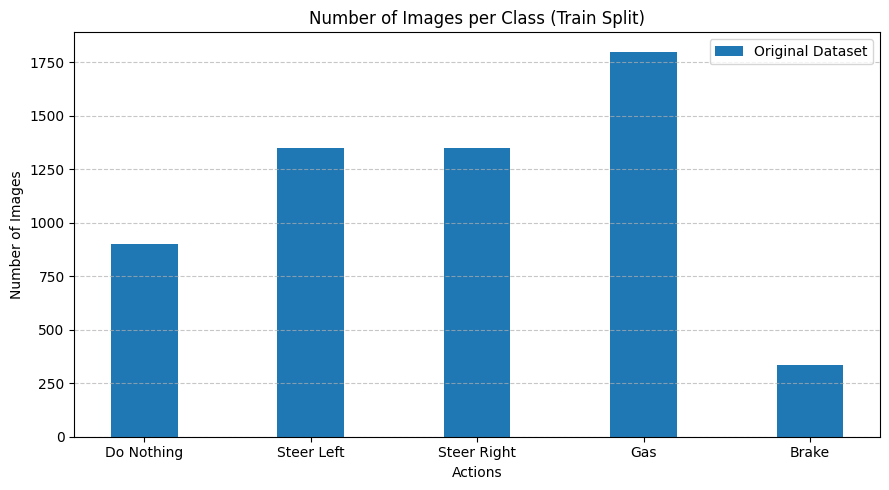

In [7]:
def enum_imgs(base_path, split="train"):
    counts = []
    for action in range(5):
        class_dir = os.path.join(base_path, split, str(action))
        counts.append(len(os.listdir(class_dir)))
    return counts

# Count images for "dataset" and "preprocessed_dataset"
dataset_counts = enum_imgs(dataset_split_path, split="train")

# Plotting
x_labels = ["Do Nothing", "Steer Left", "Steer Right", "Gas", "Brake"]
x = np.arange(len(x_labels))

plt.figure(figsize=(9, 5))

# Original dataset
plt.bar(x, dataset_counts, width=0.4, label="Original Dataset", align="center")

# Formatting the plot
plt.xticks(x, x_labels)
plt.xlabel("Actions")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class (Train Split)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


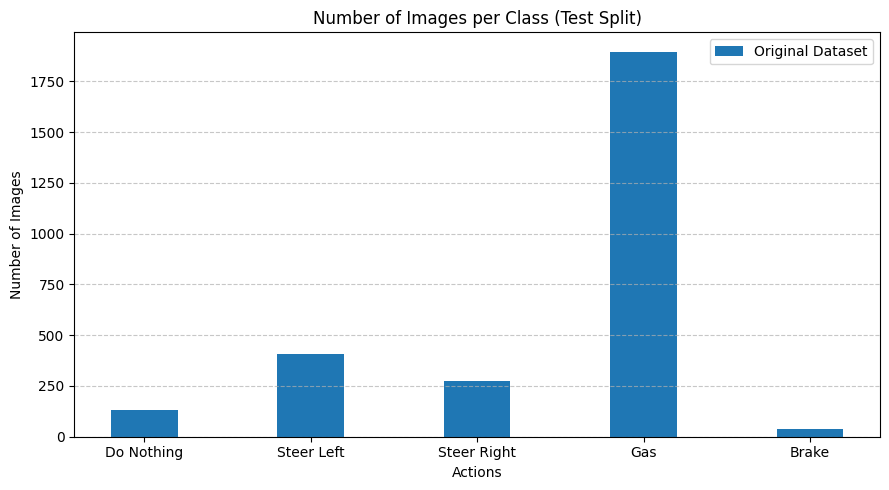

In [8]:
# Count images for "dataset" and "preprocessed_dataset"
dataset_counts = enum_imgs(dataset_split_path, split="test")

# Plotting
x_labels = ["Do Nothing", "Steer Left", "Steer Right", "Gas", "Brake"]
x = np.arange(len(x_labels))

plt.figure(figsize=(9, 5))

# Original dataset
plt.bar(x, dataset_counts, width=0.4, label="Original Dataset", align="center")

# Formatting the plot
plt.xticks(x, x_labels)
plt.xlabel("Actions")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class (Test Split)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

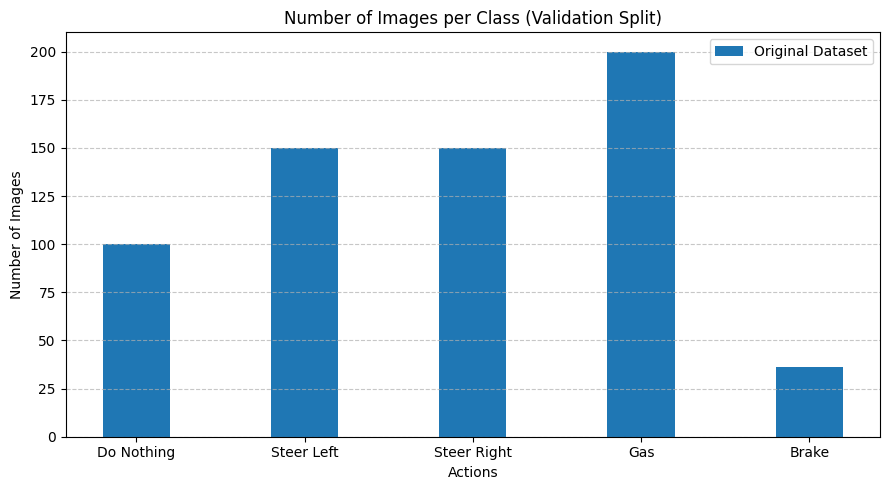

In [31]:
# Count images for "dataset" and "preprocessed_dataset"
dataset_counts = enum_imgs(dataset_split_path, split="validation")

# Plotting
x_labels = ["Do Nothing", "Steer Left", "Steer Right", "Gas", "Brake"]
x = np.arange(len(x_labels))

plt.figure(figsize=(9, 5))

# Original dataset
plt.bar(x, dataset_counts, width=0.4, label="Original Dataset", align="center")

# Formatting the plot
plt.xticks(x, x_labels)
plt.xlabel("Actions")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class (Validation Split)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

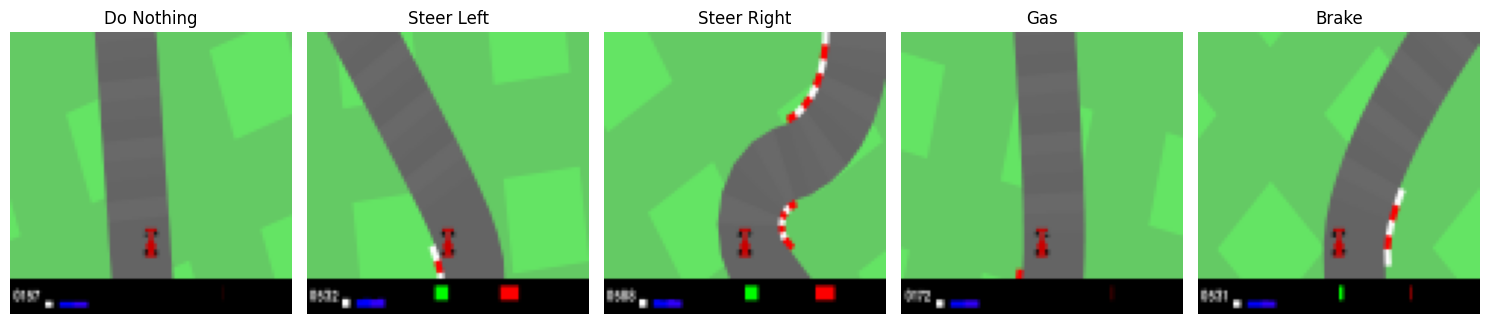

In [39]:
def plot_random_images_from_train(train_dir):
    """
    This function randomly selects and plots one image from each subfolder within the 'train' directory.
    It traverses all subdirectories of the specified 'train' folder, selects a random image from each subfolder,
    and generates a visual plot for these randomly selected images.
    This is useful for quickly visualizing a subset of the training data and verifying its structure or contents
    """

    subfolders = sorted([f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))])

    plt.figure(figsize=(15, 5))

    for i, subfolder in enumerate(subfolders):
        folder_path = os.path.join(train_dir, subfolder)
        
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"Nessuna immagine trovata nella cartella {subfolder}")
            continue
        
        random_image_file = np.random.choice(image_files)
        image_path = os.path.join(folder_path, random_image_file)
        
        image = Image.open(image_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(action_labels.get(subfolder, subfolder))
        plt.axis("off")

    plt.tight_layout()
    plt.show()
  
plot_random_images_from_train(train_dataset_path)

## Creation dataset
The following are necessary for the creation fo train and test dataset for the training of CNN

In [27]:
# Transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dataset_path, transform=transform)
validation_dataset = datasets.ImageFolder(validation_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=transform)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5733
Number of validation samples: 636
Number of test samples: 2749


# 1 CNN

In [12]:
def create_cnn_model(input_shape=(3, 96, 96), num_classes=5):
    """
    Creates a reduced CNN model for image classification using PyTorch.

    Args:
        input_shape (tuple): Shape of the input images (channels, height, width).
        num_classes (int): Number of classes for classification.

    Returns:
        nn.Module: CNN model.
    """
    class CNNModel(nn.Module):
        def __init__(self):
            super(CNNModel, self).__init__()
            
            # Convolutional Layers
            self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
            self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            
            # Pooling Layer
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

            # Calculate the size of the flattened layer dynamically
            dummy_input = torch.zeros(1, *input_shape)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            flattened_size = x.numel()

            # Fully Connected Layers
            self.fc1 = nn.Linear(flattened_size, 64)
            self.fc2 = nn.Linear(64, num_classes)

        def forward(self, x):
            # Convolutional layers with ReLU and Pooling
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))

            # Flatten
            x = x.view(x.size(0), -1)

            # Fully connected layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x

    return CNNModel()



model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)
model = model.to(device)

# Print the summary of the model
summary(model, input_size=input_shape, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]             448
         MaxPool2d-2           [-1, 16, 48, 48]               0
            Conv2d-3           [-1, 32, 48, 48]           4,640
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Linear-7                   [-1, 64]         589,888
            Linear-8                    [-1, 5]             325
Total params: 613,797
Trainable params: 613,797
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 2.46
Params size (MB): 2.34
Estimated Total Size (MB): 4.91
----------------------------------------------------------------


# 2 CNN

In [13]:
def create_deep_cnn_model(input_shape=(3, 96, 96), num_classes=5):
    """
    Creates a deeper CNN model for image classification using PyTorch.

    Args:
        input_shape (tuple): Shape of the input images (channels, height, width).
        num_classes (int): Number of classes for classification.

    Returns:
        nn.Module: CNN model.
    """
    class DeepCNNModel(nn.Module):
        def __init__(self):
            super(DeepCNNModel, self).__init__()
            
            # Convolutional Layers
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)
            self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.bn4 = nn.BatchNorm2d(256)
            
            # Pooling Layer
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

            # Calculate the size of the flattened layer dynamically
            dummy_input = torch.zeros(1, *input_shape)
            x = self.pool(F.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.pool(F.relu(self.bn4(self.conv4(x))))
            flattened_size = x.numel()

            # Fully Connected Layers
            self.fc1 = nn.Linear(flattened_size, 1024)
            self.fc2 = nn.Linear(1024, num_classes)

        def forward(self, x):
            # Convolutional layers with ReLU and Pooling
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            x = self.pool(F.relu(self.bn4(self.conv4(x))))

            # Flatten
            x = x.view(x.size(0), -1)

            # Fully connected layers
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x

    return DeepCNNModel()

model = create_deep_cnn_model()
model = model.to(device)

# Print the summary of the model
summary(model, input_size=input_shape, device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             896
       BatchNorm2d-2           [-1, 32, 96, 96]              64
         MaxPool2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          18,496
       BatchNorm2d-5           [-1, 64, 48, 48]             128
         MaxPool2d-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 24, 24]          73,856
       BatchNorm2d-8          [-1, 128, 24, 24]             256
         MaxPool2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
           Linear-13                 [-1, 1024]       9,438,208
           Linear-14                   

# Train, HyperParameter search and Test
The follwing code are used in order to perform the train with hyperparameter search and plot of train and validation loss

In [14]:
def plot_loss(save_path, name_plot, best_model_info):

    # Plotting train loss and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(best_model_info["epoch"], best_model_info["train_loss"], label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Loss")
    
    # Plotting train accuracy
    plt.subplot(2, 1, 2)
    plt.plot(best_model_info["epoch"],  best_model_info["train_accuracy"], label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training Accuracy")

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, name_plot))
    plt.show()

In [15]:
def test_model(model, model_path, test_loader, device, show):
    if show:
        model.load_state_dict(torch.load(model_path, weights_only=False)['model_state_dict'])
        
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    if show:
        print(f"Test Accuracy: {accuracy:.4f}")

    # Creation of Classification Report
    if show:
        report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes)
    else:
        report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes, output_dict=True)
    if show:
        print("Classification Report:\n", report)

    # Confusion Matrix
    if show:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, report

In [16]:
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.to(device)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        print(f"Epoch {epoch + 1}/{num_epochs}")

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            train_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss /= len(train_loader)
        train_accuracy = correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    return train_losses, train_accuracies

In [17]:
def hyperparameter_search(num, train_data, validation_data, param_grid, save_path, name_model, num_epochs, device):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    best_params = None
    best_accuracy = 0
    best_f1_score = 0
    best_recall = 0
    best_precision = 0
    best_model_info = None

    results_file_path = os.path.join(save_path, f"{name_model}_results.txt")
    with open(results_file_path, "w") as results_file:
        for params in ParameterGrid(param_grid):
            print(f"Testing params: {params}")

            if num == 1:
                model = create_cnn_model()
            else:
                model = create_deep_cnn_model()

            # Initialize optimizer and loss function
            optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
            criterion = nn.CrossEntropyLoss()

            # Create DataLoader
            train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

            # Train model and collect losses and predictions
            train_losses, train_accuracies = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

            # Evaluate model on validation set
            model_path = None
            accuracy, classification_metrics = test_model(model, model_path, validation_loader, device, show=False)

            # Compute average precision, recall, and F1-score across all classes
            precision_avg = classification_metrics['weighted avg']['precision']
            recall_avg = classification_metrics['weighted avg']['recall']
            f1_score_avg = classification_metrics['weighted avg']['f1-score']

            # Save results to file
            results_file.write(f"MODEL BATCH_SIZE={params['batch_size']} LEARNING_RATE={params['learning_rate']} OPTIMIZER={params['optimizer']}\n")
            results_file.write(f"ACCURACY={accuracy} PRECISION={precision_avg} RECALL={recall_avg} F1_SCORE={f1_score_avg}\n\n")

            if accuracy > best_accuracy and precision_avg > best_precision:
                best_accuracy = accuracy
                best_f1_score = f1_score_avg
                best_precision = precision_avg
                best_recall = recall_avg
                best_params = params
                best_model_info = {
                    "epoch": list(range(1, num_epochs + 1)),
                    "train_loss": train_losses,
                    "train_accuracy": train_accuracies,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "hyperparameters": params
                }

                # Save the best model
                torch.save(best_model_info, os.path.join(save_path, name_model))

    print(f"Best Params: {best_params}, Best Accuracy: {best_accuracy}, Best Average Precision: {best_precision}")
    return best_params, best_model_info

# Train and Test of 1 CNN

In [18]:
name_plot="TRAIN_VAL_LOSS_1_CNN.png"
save_path="SAVE/NO_PREPROCESSED"
name_model="1_CNN.pth"
num = 1
best_params, best_model_info = hyperparameter_search(num, train_dataset, validation_dataset, param_grid, save_path, name_model, num_epochs, device)

print(f"Best hyperparameters: {best_params}")

Testing params: {'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.2843, Train Accuracy: 0.5186
Epoch 2/20
Train Loss: 1.1459, Train Accuracy: 0.5843
Epoch 3/20
Train Loss: 1.0958, Train Accuracy: 0.5988
Epoch 4/20
Train Loss: 1.0672, Train Accuracy: 0.6058
Epoch 5/20
Train Loss: 1.0533, Train Accuracy: 0.6108
Epoch 6/20
Train Loss: 1.0181, Train Accuracy: 0.6279
Epoch 7/20
Train Loss: 0.9808, Train Accuracy: 0.6400
Epoch 8/20
Train Loss: 0.9588, Train Accuracy: 0.6490
Epoch 9/20
Train Loss: 0.9461, Train Accuracy: 0.6457
Epoch 10/20
Train Loss: 0.9258, Train Accuracy: 0.6618
Epoch 11/20
Train Loss: 0.9104, Train Accuracy: 0.6667
Epoch 12/20
Train Loss: 0.8982, Train Accuracy: 0.6719
Epoch 13/20
Train Loss: 0.8683, Train Accuracy: 0.6794
Epoch 14/20
Train Loss: 0.8520, Train Accuracy: 0.6923
Epoch 15/20
Train Loss: 0.8311, Train Accuracy: 0.6944
Epoch 16/20
Train Loss: 0.8282, Train Accuracy: 0.6984
Epoch 17/20
Train Loss: 0.8078, Train Accuracy: 0.

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.2323, Train Accuracy: 0.5294
Epoch 2/20
Train Loss: 1.0889, Train Accuracy: 0.6021
Epoch 3/20
Train Loss: 1.0373, Train Accuracy: 0.6157
Epoch 4/20
Train Loss: 0.9923, Train Accuracy: 0.6316
Epoch 5/20
Train Loss: 0.9534, Train Accuracy: 0.6506
Epoch 6/20
Train Loss: 0.9307, Train Accuracy: 0.6620
Epoch 7/20
Train Loss: 0.8846, Train Accuracy: 0.6820
Epoch 8/20
Train Loss: 0.8475, Train Accuracy: 0.6921
Epoch 9/20
Train Loss: 0.8190, Train Accuracy: 0.7085
Epoch 10/20
Train Loss: 0.7741, Train Accuracy: 0.7227
Epoch 11/20
Train Loss: 0.7415, Train Accuracy: 0.7340
Epoch 12/20
Train Loss: 0.7063, Train Accuracy: 0.7492
Epoch 13/20
Train Loss: 0.6692, Train Accuracy: 0.7607
Epoch 14/20
Train Loss: 0.6335, Train Accuracy: 0.7724
Epoch 15/20
Train Loss: 0.5939, Train Accuracy: 0.7874
Epoch 16/20
Train Loss: 0.5660, Train Accuracy: 0.7961
Epoch 17/20
Train Loss: 0.5205, Train Accuracy: 0

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.3878, Train Accuracy: 0.4636
Epoch 2/20
Train Loss: 1.1930, Train Accuracy: 0.5589
Epoch 3/20
Train Loss: 1.1543, Train Accuracy: 0.5746
Epoch 4/20
Train Loss: 1.1327, Train Accuracy: 0.5800
Epoch 5/20
Train Loss: 1.1092, Train Accuracy: 0.5859
Epoch 6/20
Train Loss: 1.0948, Train Accuracy: 0.5920
Epoch 7/20
Train Loss: 1.0747, Train Accuracy: 0.6072
Epoch 8/20
Train Loss: 1.0632, Train Accuracy: 0.6039
Epoch 9/20
Train Loss: 1.0508, Train Accuracy: 0.6091
Epoch 10/20
Train Loss: 1.0419, Train Accuracy: 0.6126
Epoch 11/20
Train Loss: 1.0306, Train Accuracy: 0.6140
Epoch 12/20
Train Loss: 1.0206, Train Accuracy: 0.6252
Epoch 13/20
Train Loss: 1.0195, Train Accuracy: 0.6197
Epoch 14/20
Train Loss: 1.0083, Train Accuracy: 0.6286
Epoch 15/20
Train Loss: 1.0044, Train Accuracy: 0.6255
Epoch 16/20
Train Loss: 1.0004, Train Accuracy: 0.6241
Epoch 17/20
Train Loss: 0.9876, Train Accuracy: 

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 64, 'learning_rate': 0.01, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.2876, Train Accuracy: 0.5407
Epoch 2/20
Train Loss: 1.0971, Train Accuracy: 0.6002
Epoch 3/20
Train Loss: 1.0344, Train Accuracy: 0.6227
Epoch 4/20
Train Loss: 0.9886, Train Accuracy: 0.6368
Epoch 5/20
Train Loss: 0.9440, Train Accuracy: 0.6440
Epoch 6/20
Train Loss: 0.9061, Train Accuracy: 0.6661
Epoch 7/20
Train Loss: 0.8596, Train Accuracy: 0.6797
Epoch 8/20
Train Loss: 0.8290, Train Accuracy: 0.6958
Epoch 9/20
Train Loss: 0.7882, Train Accuracy: 0.7038
Epoch 10/20
Train Loss: 0.7483, Train Accuracy: 0.7241
Epoch 11/20
Train Loss: 0.7171, Train Accuracy: 0.7286
Epoch 12/20
Train Loss: 0.6714, Train Accuracy: 0.7520
Epoch 13/20
Train Loss: 0.6383, Train Accuracy: 0.7623
Epoch 14/20
Train Loss: 0.6158, Train Accuracy: 0.7745
Epoch 15/20
Train Loss: 0.5876, Train Accuracy: 0.7813
Epoch 16/20
Train Loss: 0.5656, Train Accuracy: 0.7907
Epoch 17/20
Train Loss: 0.5391, Train Accuracy: 0.

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.2810, Train Accuracy: 0.5017
Epoch 2/20
Train Loss: 1.1224, Train Accuracy: 0.5850
Epoch 3/20
Train Loss: 1.0811, Train Accuracy: 0.6074
Epoch 4/20
Train Loss: 1.0256, Train Accuracy: 0.6245
Epoch 5/20
Train Loss: 0.9861, Train Accuracy: 0.6342
Epoch 6/20
Train Loss: 0.9676, Train Accuracy: 0.6356
Epoch 7/20
Train Loss: 0.9318, Train Accuracy: 0.6611
Epoch 8/20
Train Loss: 0.8967, Train Accuracy: 0.6728
Epoch 9/20
Train Loss: 0.8696, Train Accuracy: 0.6796
Epoch 10/20
Train Loss: 0.8321, Train Accuracy: 0.6953
Epoch 11/20
Train Loss: 0.8059, Train Accuracy: 0.7120
Epoch 12/20
Train Loss: 0.7784, Train Accuracy: 0.7214
Epoch 13/20
Train Loss: 0.7452, Train Accuracy: 0.7342
Epoch 14/20
Train Loss: 0.7207, Train Accuracy: 0.7429
Epoch 15/20
Train Loss: 0.6908, Train Accuracy: 0.7556
Epoch 16/20
Train Loss: 0.6512, Train Accuracy: 0.7685
Epoch 17/20
Train Loss: 0.6252, Train Accuracy: 0

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.4999, Train Accuracy: 0.3239
Epoch 2/20
Train Loss: 1.3255, Train Accuracy: 0.5119
Epoch 3/20
Train Loss: 1.1857, Train Accuracy: 0.5608
Epoch 4/20
Train Loss: 1.1578, Train Accuracy: 0.5697
Epoch 5/20
Train Loss: 1.1408, Train Accuracy: 0.5781
Epoch 6/20
Train Loss: 1.1185, Train Accuracy: 0.5904
Epoch 7/20
Train Loss: 1.1102, Train Accuracy: 0.5938
Epoch 8/20
Train Loss: 1.0933, Train Accuracy: 0.5964
Epoch 9/20
Train Loss: 1.0837, Train Accuracy: 0.6020
Epoch 10/20
Train Loss: 1.0713, Train Accuracy: 0.6061
Epoch 11/20
Train Loss: 1.0632, Train Accuracy: 0.6122
Epoch 12/20
Train Loss: 1.0477, Train Accuracy: 0.6110
Epoch 13/20
Train Loss: 1.0448, Train Accuracy: 0.6129
Epoch 14/20
Train Loss: 1.0293, Train Accuracy: 0.6178
Epoch 15/20
Train Loss: 1.0176, Train Accuracy: 0.6210
Epoch 16/20
Train Loss: 1.0141, Train Accuracy: 0.6260
Epoch 17/20
Train Loss: 1.0048, Train Accuracy: 

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

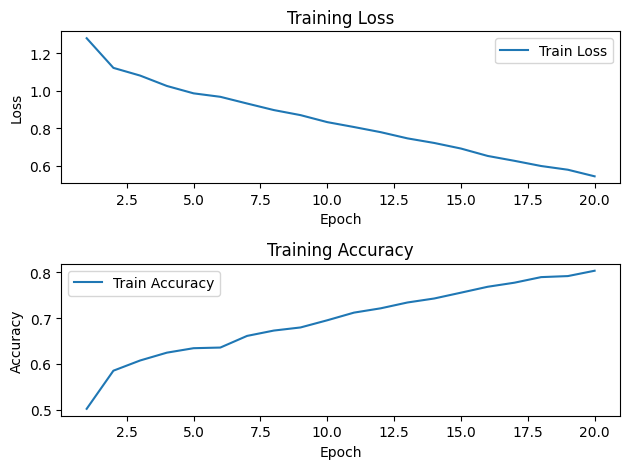

In [19]:
plot_loss(save_path, name_plot, best_model_info)

Test Accuracy: 0.5424
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.50      0.26       133
           1       0.47      0.62      0.54       406
           2       0.33      0.56      0.41       275
           3       0.86      0.53      0.66      1896
           4       0.04      0.21      0.07        39

    accuracy                           0.54      2749
   macro avg       0.38      0.48      0.39      2749
weighted avg       0.71      0.54      0.59      2749



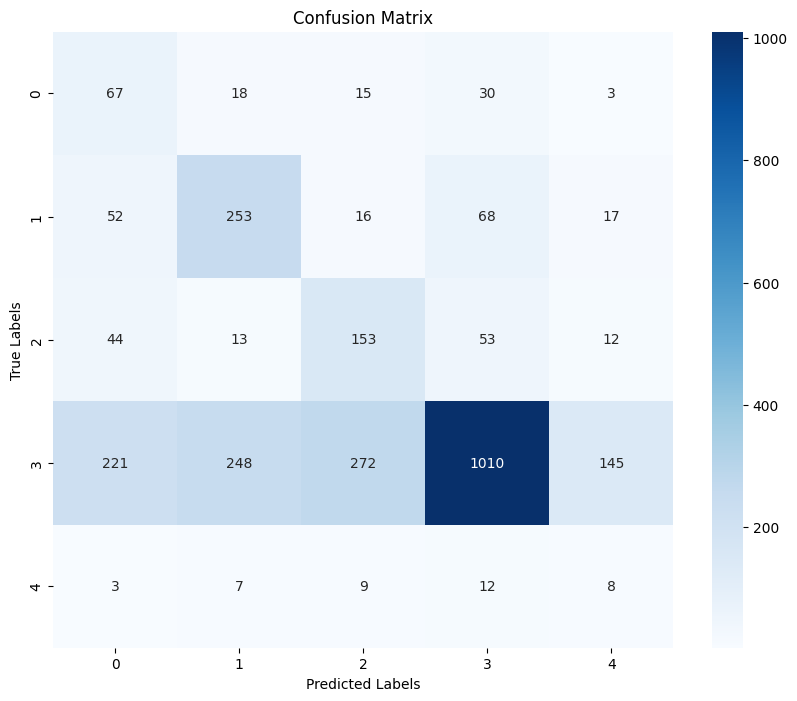

In [20]:

model_path = "SAVE/NO_PREPROCESSED/1_CNN.pth"
model = create_cnn_model()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy, report = test_model(model, model_path, test_loader, device, show=True)

# Train and Test of 2 CNN

In [28]:
name_plot="TRAIN_VAL_LOSS_2_CNN.png"
save_path="SAVE/NO_PREPROCESSED"
name_model="2_CNN.pth"
num = 2
best_params, best_model_info = hyperparameter_search(num, train_dataset, validation_dataset, param_grid, save_path, name_model, num_epochs, device)

print(f"Best hyperparameters: {best_params}")

Testing params: {'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 15.3341, Train Accuracy: 0.4481
Epoch 2/20
Train Loss: 1.2140, Train Accuracy: 0.5576
Epoch 3/20
Train Loss: 1.1757, Train Accuracy: 0.5679
Epoch 4/20
Train Loss: 1.1518, Train Accuracy: 0.5777
Epoch 5/20
Train Loss: 1.1060, Train Accuracy: 0.5904
Epoch 6/20
Train Loss: 1.0890, Train Accuracy: 0.6011
Epoch 7/20
Train Loss: 1.0676, Train Accuracy: 0.6135
Epoch 8/20
Train Loss: 1.0407, Train Accuracy: 0.6204
Epoch 9/20
Train Loss: 1.0205, Train Accuracy: 0.6290
Epoch 10/20
Train Loss: 0.9984, Train Accuracy: 0.6445
Epoch 11/20
Train Loss: 0.9834, Train Accuracy: 0.6447
Epoch 12/20
Train Loss: 0.9526, Train Accuracy: 0.6539
Epoch 13/20
Train Loss: 0.9297, Train Accuracy: 0.6667
Epoch 14/20
Train Loss: 0.8997, Train Accuracy: 0.6738
Epoch 15/20
Train Loss: 0.8840, Train Accuracy: 0.6796
Epoch 16/20
Train Loss: 0.8656, Train Accuracy: 0.6913
Epoch 17/20
Train Loss: 0.8474, Train Accuracy: 0

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 32, 'learning_rate': 0.0001, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.2065, Train Accuracy: 0.5508
Epoch 2/20
Train Loss: 1.0563, Train Accuracy: 0.6136
Epoch 3/20
Train Loss: 0.9868, Train Accuracy: 0.6391
Epoch 4/20
Train Loss: 0.9127, Train Accuracy: 0.6693
Epoch 5/20
Train Loss: 0.8575, Train Accuracy: 0.6932
Epoch 6/20
Train Loss: 0.7780, Train Accuracy: 0.7272
Epoch 7/20
Train Loss: 0.7230, Train Accuracy: 0.7466
Epoch 8/20
Train Loss: 0.6582, Train Accuracy: 0.7727
Epoch 9/20
Train Loss: 0.6056, Train Accuracy: 0.7900
Epoch 10/20
Train Loss: 0.5403, Train Accuracy: 0.8139
Epoch 11/20
Train Loss: 0.4949, Train Accuracy: 0.8343
Epoch 12/20
Train Loss: 0.4299, Train Accuracy: 0.8503
Epoch 13/20
Train Loss: 0.3870, Train Accuracy: 0.8662
Epoch 14/20
Train Loss: 0.3494, Train Accuracy: 0.8772
Epoch 15/20
Train Loss: 0.3049, Train Accuracy: 0.8938
Epoch 16/20
Train Loss: 0.2742, Train Accuracy: 0.9081
Epoch 17/20
Train Loss: 0.2443, Train Accuracy: 

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 64, 'learning_rate': 0.01, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 23.4434, Train Accuracy: 0.2700
Epoch 2/20
Train Loss: 1.3158, Train Accuracy: 0.4994
Epoch 3/20
Train Loss: 1.1512, Train Accuracy: 0.5726
Epoch 4/20
Train Loss: 1.1180, Train Accuracy: 0.5946
Epoch 5/20
Train Loss: 1.0939, Train Accuracy: 0.5962
Epoch 6/20
Train Loss: 1.0767, Train Accuracy: 0.6056
Epoch 7/20
Train Loss: 1.0471, Train Accuracy: 0.6147
Epoch 8/20
Train Loss: 1.0257, Train Accuracy: 0.6225
Epoch 9/20
Train Loss: 1.0068, Train Accuracy: 0.6269
Epoch 10/20
Train Loss: 0.9823, Train Accuracy: 0.6388
Epoch 11/20
Train Loss: 0.9610, Train Accuracy: 0.6489
Epoch 12/20
Train Loss: 0.9518, Train Accuracy: 0.6510
Epoch 13/20
Train Loss: 0.9214, Train Accuracy: 0.6632
Epoch 14/20
Train Loss: 0.9027, Train Accuracy: 0.6674
Epoch 15/20
Train Loss: 0.8768, Train Accuracy: 0.6771
Epoch 16/20
Train Loss: 0.8559, Train Accuracy: 0.6893
Epoch 17/20
Train Loss: 0.8315, Train Accuracy: 0

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Testing params: {'batch_size': 64, 'learning_rate': 0.0001, 'optimizer': 'Adam'}
Epoch 1/20
Train Loss: 1.2351, Train Accuracy: 0.5418
Epoch 2/20
Train Loss: 1.0637, Train Accuracy: 0.5995
Epoch 3/20
Train Loss: 0.9836, Train Accuracy: 0.6421
Epoch 4/20
Train Loss: 0.9155, Train Accuracy: 0.6677
Epoch 5/20
Train Loss: 0.8559, Train Accuracy: 0.6949
Epoch 6/20
Train Loss: 0.7921, Train Accuracy: 0.7176
Epoch 7/20
Train Loss: 0.7370, Train Accuracy: 0.7405
Epoch 8/20
Train Loss: 0.6532, Train Accuracy: 0.7786
Epoch 9/20
Train Loss: 0.5991, Train Accuracy: 0.7933
Epoch 10/20
Train Loss: 0.5446, Train Accuracy: 0.8198
Epoch 11/20
Train Loss: 0.4833, Train Accuracy: 0.8380
Epoch 12/20
Train Loss: 0.4278, Train Accuracy: 0.8613
Epoch 13/20
Train Loss: 0.3747, Train Accuracy: 0.8823
Epoch 14/20
Train Loss: 0.3432, Train Accuracy: 0.8898
Epoch 15/20
Train Loss: 0.3041, Train Accuracy: 0.8999
Epoch 16/20
Train Loss: 0.2680, Train Accuracy: 0.9149
Epoch 17/20
Train Loss: 0.2388, Train Accuracy: 

c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\Desktop\machine _Learning\HW2\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

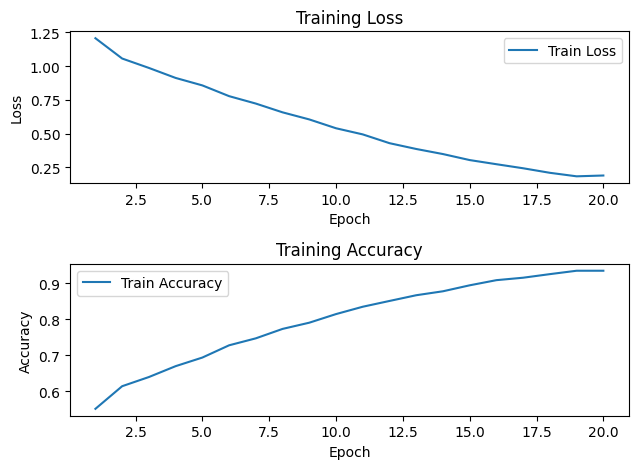

In [29]:
plot_loss(save_path, name_plot, best_model_info)

Test Accuracy: 0.4638
Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.41      0.23       133
           1       0.44      0.73      0.55       406
           2       0.28      0.79      0.41       275
           3       0.91      0.37      0.53      1896
           4       0.02      0.10      0.03        39

    accuracy                           0.46      2749
   macro avg       0.36      0.48      0.35      2749
weighted avg       0.73      0.46      0.50      2749



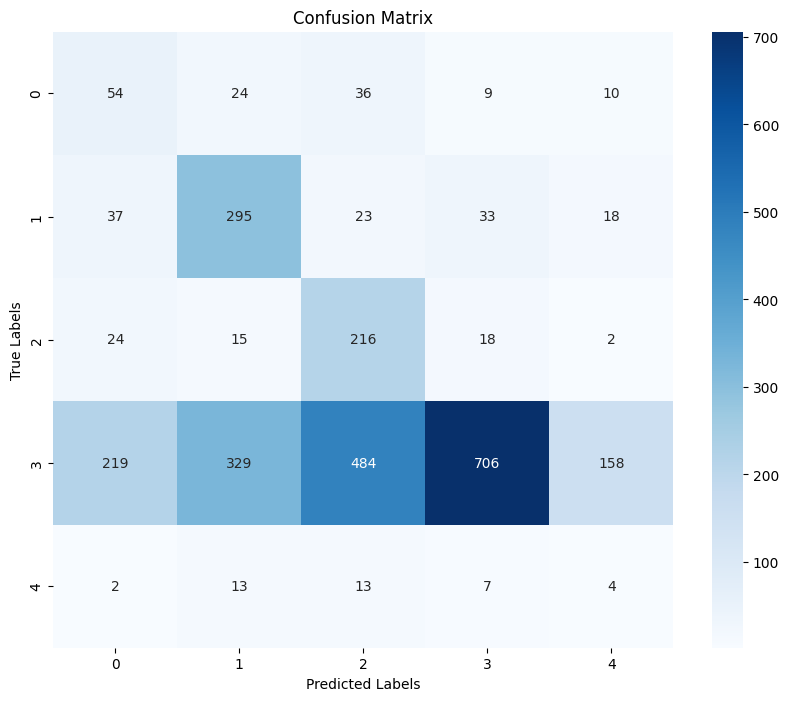

In [30]:
model_path = "SAVE/NO_PREPROCESSED/2_CNN.pth"
model = create_deep_cnn_model()
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
accuracy, report = test_model(model, model_path, test_loader, device, show=True)